In [42]:
import geopandas as gpd
import fiona
import pandas as pd
from sklearn.preprocessing import MinMaxScaler



# --- 1. Chargement et nettoyage du fichier BDZI ---


In [43]:
import fiona



In [51]:

path = "../data/BDZI.gdb"
bdzi = gpd.read_file(path, layer="ZOI_s", engine="fiona")

print(len(bdzi))
print(bdzi.columns)

montreal = gpd.read_file("../data/Limites-administratives-agglomération/limites-administratives-agglomeration-nad83.shp", engine="fiona")  # limite administrative de Montréal



954
Index(['Indicatif', 'Description', 'Id_uni_Zoi', 'No_rapport', 'Nm_rapport',
       'Date_rapport', 'Etat', 'Nm_prog', 'Nm_part', 'Form_orig', 'Version',
       'Proprio', 'date_debut', 'date_fin', 'Shape_Length', 'Shape_Area',
       'geometry'],
      dtype='object')


In [52]:

# --- 2. Nettoyage de base ---
bdzi.columns = bdzi.columns.str.lower().str.strip()
cols = [c for c in ["id_uni_zoi", "description", "etat", "geometry"] if c in bdzi.columns]
bdzi = bdzi[cols].copy()

# Standardisation des textes
bdzi["description"] = bdzi["description"].astype(str).str.lower().str.strip()
bdzi["etat"] = bdzi["etat"].astype(str).str.lower().str.strip()

# --- 3. Filtrer uniquement les zones actives ---
bdzi = bdzi[bdzi["etat"] == "actif"].reset_index(drop=True)

print("Zones actives :", len(bdzi))
bdzi.head()



Zones actives : 954


,id_uni_zoi,description,etat,geometry
0,010200005,zone de grand courant,actif,"MULTIPOLYGON (((-8118180.24 5786080.856, -8118..."
1,010200006,zone de faible courant,actif,"MULTIPOLYGON (((-8118143.999 5786080.998, -811..."
2,010200007,zone de faible courant - pont,actif,"MULTIPOLYGON (((-8114700.956 5776455.69, -8114..."
3,010200008,zone de grand courant - pont,actif,"MULTIPOLYGON (((-8114702.551 5776459.435, -811..."
4,010200009,zone de faible courant,actif,"MULTIPOLYGON (((-8142750.624 5752236.742, -814..."


In [57]:

# --- 4. Harmoniser les projections ---
montreal = montreal.to_crs(bdzi.crs)

# --- 5. Garder uniquement les zones dans Montréal ---
bdzi_mtl = gpd.overlay(bdzi, montreal, how="intersection")

print("Zones d’inondation dans Montréal :", len(bdzi_mtl))





Zones d’inondation dans Montréal : 14


In [79]:
cols = [c for c in ["id_uni_zoi", "description", "etat", "geometry"] if c in bdzi_mtl.columns]
bdzi_mtl = bdzi_mtl[cols].copy()

bdzi_mtl.head()


,id_uni_zoi,description,etat,geometry
0,010100713,zone de grand courant,actif,"MULTIPOLYGON (((-8232152.597 5691947.467, -823..."
1,010100713,zone de grand courant,actif,"MULTIPOLYGON (((-8228125.601 5691902.524, -822..."
2,010100713,zone de grand courant,actif,"MULTIPOLYGON (((-8230952.386 5697109.392, -823..."
3,010100713,zone de grand courant,actif,"MULTIPOLYGON (((-8230795.006 5694501.603, -823..."
4,010100711,zone de faible courant,actif,"MULTIPOLYGON (((-8234797.195 5688009.401, -823..."


In [80]:
import re


In [81]:

# --- 4. Extraire les infos de la description ---
def extraire_infos(desc):
    """
    Analyse le texte pour extraire :
    - type de courant (grand/faible)
    - période de retour (0-2, 0-20, 0-100)
    - mention de pont ou barrage
    """
    type_courant = None
    if "grand courant" in desc:
        type_courant = "grand courant"
    elif "faible courant" in desc:
        type_courant = "faible courant"
    elif "crue" in desc:
        type_courant = "crue"
    elif "hautes eaux" in desc:
        type_courant = "hautes eaux"
    else:
        type_courant = "autre"

    # Période de retour (ex: 0-20 ans, 0-100 ans)
    match = re.search(r"0-?(\d+)", desc)
    retour = int(match.group(1)) if match else None

    # Indique si c’est un pont ou barrage
    pont = int("pont" in desc)
    barrage = int("barrage" in desc)

    return pd.Series([type_courant, retour, pont, barrage])

bdzi_mtl[["type_inondation", "periode_retour", "pont", "barrage"]] = bdzi_mtl["description"].apply(extraire_infos)

# --- 5. Attribuer un score d’intensité ---
def calcul_score(row):
    base = {"grand courant": 1.0, "crue": 0.8, "faible courant": 0.6,
            "hautes eaux": 0.4, "autre": 0.3}[row["type_inondation"]]

    # Plus la période de retour est courte, plus le risque est fort
    if pd.notna(row["periode_retour"]):
        if row["periode_retour"] <= 2:
            periode = 1.0
        elif row["periode_retour"] <= 20:
            periode = 0.8
        elif row["periode_retour"] <= 100:
            periode = 0.6
        else:
            periode = 0.5
    else:
        periode = 0.7

    # Pont ou barrage = ajustement léger
    bonus = 0.1 if row["pont"] or row["barrage"] else 0.0

    return min(1.0, base * 0.7 + periode * 0.3 + bonus)

bdzi_mtl["indice_inondation"] = bdzi_mtl.apply(calcul_score, axis=1)

bdzi_mtl.head()



,id_uni_zoi,description,etat,geometry,type_inondation,periode_retour,pont,barrage,indice_inondation
0,010100713,zone de grand courant,actif,"MULTIPOLYGON (((-8232152.597 5691947.467, -823...",grand courant,NaN,0,0,0.91
1,010100713,zone de grand courant,actif,"MULTIPOLYGON (((-8228125.601 5691902.524, -822...",grand courant,NaN,0,0,0.91
2,010100713,zone de grand courant,actif,"MULTIPOLYGON (((-8230952.386 5697109.392, -823...",grand courant,NaN,0,0,0.91
3,010100713,zone de grand courant,actif,"MULTIPOLYGON (((-8230795.006 5694501.603, -823...",grand courant,NaN,0,0,0.91
4,010100711,zone de faible courant,actif,"MULTIPOLYGON (((-8234797.195 5688009.401, -823...",faible courant,NaN,0,0,0.63


# Decoupage pour la ville de Montreal

In [82]:
import matplotlib.pyplot as plt


In [84]:

print("CRS :", bdzi_mtl.crs)
print("Nombre total :", len(bdzi_mtl))
print("Nombre de géométries valides :", bdzi_mtl.geometry.notnull().sum())
print("Borne min/max :", bdzi_mtl.total_bounds)

CRS : EPSG:3857
Nombre total : 14
Nombre de géométries valides : 14
Borne min/max : [-8237264.07052723  5682400.74726458 -8209532.28695515  5704555.606     ]


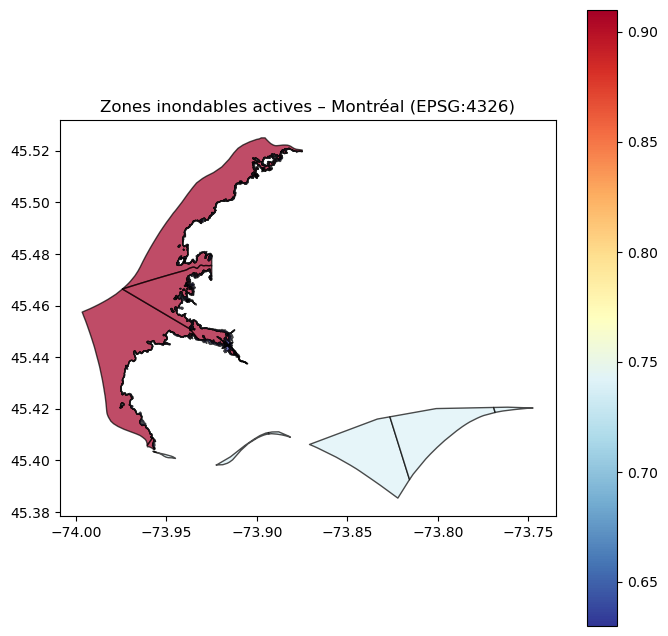

In [85]:
bdzi_mtl = bdzi_mtl.to_crs(epsg=4326)  # reprojection en latitude/longitude

ax = bdzi_mtl.plot(
    column="indice_inondation",
    cmap="RdYlBu_r",
    legend=True,
    figsize=(8, 8),
    alpha=0.7,
    edgecolor="black"
)
ax.set_title("Zones inondables actives – Montréal (EPSG:4326)")
plt.show()

### Observation — Zones inondables actives (Montréal)

La carte montre les zones classées comme inondables actives selon la base géospatiale.  
On constate que **ces zones se situent majoritairement à la périphérie de l’île**, notamment à l’ouest et au sud-est, loin du centre urbain dense et des principaux regroupements de bâtiments étudiés.  
Ainsi, **cette donnée n’est pas directement pertinente** pour notre analyse des bâtiments résidentiels et municipaux, puisque **elle ne recoupe pas les secteurs réellement urbanisés** ni les zones d’intérêt énergétique du projet.


In [86]:
bdzi_mtl.to_file("../outputs/BDZI_ZOI_s_Montreal_nettoye_WGS84.gpkg", driver="GPKG")


In [87]:
bdzi_mtl.columns

Index(['id_uni_zoi', 'description', 'etat', 'geometry', 'type_inondation',
       'periode_retour', 'pont', 'barrage', 'indice_inondation'],
      dtype='object')